In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import os, sys
import numpy as np
import pandas as pd
from scipy import io, stats
import seaborn as sns

sys.path.append('../')
import echo_utils

font = {'family' : 'Tahoma',
        'weight' : 'regular',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('image', cmap='inferno')

C_ORD = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig_path = '../figures/mni/%s.pdf'
save_plot=True

In [131]:
# load data
d_query = 4
df_W_max = pd.read_csv('../data/df_human_W_max_%i.csv'%d_query, index_col=0)
df_tau_weighted = pd.read_csv('../data/df_human_tau_weighted_%i.csv'%d_query, index_col=0)
df_struct = pd.read_csv('../data/df_structural.csv', index_col=1)
df_ecog = pd.read_csv('../data/df_human.csv', index_col=0)
mmp_aggr = pd.read_csv('../data/mmp_macro.csv', index_col=0, names=['parcel','macro_region'])

# get patient info for age-related analysis
df_patient = df_ecog.groupby('patient').mean()[['gender', 'age']].astype(int)
df_patient.index = df_patient.index.astype(int)

# Plot individual subject and aggregate coverage maps on MMP

colormap sequential: [0.00e+00, 1.50e-01, 3.00e-01] (opaque)


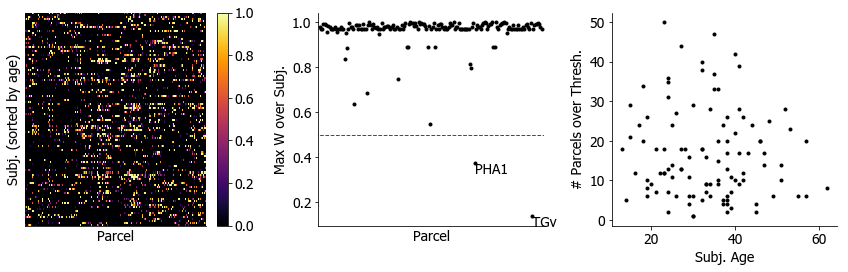

In [132]:
plot_subj_coverage = False
subj_fig_path = '../figures/mni/subj_mmp_coverage/'
if plot_subj_coverage:
    # plot aggregate max
    echo_utils.plot_MMP(np.max(df_W_max.values, axis=0), subj_fig_path+'aggregate')

    # plot individual subject map
    for s_i, s in df_W_max.iterrows():
        echo_utils.plot_MMP(s.values, subj_fig_path+'subj_%i'%int(s_i))
        
# different visualization of coverage 
w_thres = 0.5

plt.figure(figsize=(12,4))

# heat map of weight matrix (subj x parcel)
plt.subplot(1,3,1)
plt.imshow(df_W_max.values[np.argsort(df_patient['age']).values.astype(int),:], aspect='auto')
plt.xlabel('Parcel');plt.ylabel('Subj. (sorted by age)')
plt.xticks([]);plt.yticks([]); plt.colorbar()

# maximum weight in each parcel, pooled over subjects
plt.subplot(1,3,2)
region_wmax = np.max(df_W_max.values,axis=0)
plt.plot(region_wmax, 'k.')
plt.plot(plt.xlim(),[w_thres, w_thres], 'r--', lw=1)
plt.xlim([-1,len(region_wmax)+1])
plt.xlabel('Parcel');plt.ylabel('Max W over Subj.')
plt.xticks([]); sns.despine()
under_w_thresh = np.where(region_wmax<w_thres)[0]
for w in under_w_thresh:
    plt.text(w, region_wmax[w], df_W_max.columns[w], verticalalignment='top')

# # of confident parcels per subject, sorted by age
plt.subplot(1,3,3)
plt.plot(df_patient['age'], np.sum(df_W_max>=w_thres,1),'.k')
plt.xlabel('Subj. Age');plt.ylabel('# Parcels over Thresh.')
sns.despine()
    
plt.tight_layout()
if save_plot: plt.savefig(fig_path%'mni_mmp_coverage')

# percentage of patients that had coverage at that parcel
pct_coverage = (df_W_max>w_thres).mean(axis=0)
echo_utils.plot_MMP(pct_coverage.values, fig_path[:-4]%('coverage_mmp_%i'%d_query), minmax=[0,0.3])

# Tau-Expression Correlation

In [133]:
def compute_weighted_average(df_feature, df_W, w_thresh=0.5, axis=0, method='weighted'):
    if method is 'weighted':
        # method 1: weighted average of all parcels 
        #    this makes the most sense? weights all parcels, and the non-confident ones are already downweighted
        return (df_feature*df_W).sum(axis=axis)/df_W.sum(axis=axis)

    elif method is 'thresh_weighted':
        # method 2: weighted average of suprathreshold parcels
        #    this will approach method 1 as w_thresh approaches 0
        thresh_mat = df_W>=w_thres
        return (df_feature*df_W)[thresh_mat].sum(axis=axis)/df_W[thresh_mat].sum(axis=axis)
    
    elif method is 'thresh_mean':
        # method 3: simple average of suprathreshold parcels
        #    not sure if it makes sense to weight all suprathreshold parcels equally
        thresh_mat = df_W>=w_thres
        return np.nanmean((df_feature*df_W)[thresh_mat],axis=axis)

colormap sequential: [-2.43e+00, 1.37e-01, 2.71e+00] (opaque)
colormap sequential: [0.00e+00, 2.50e-02, 5.00e-02] (opaque)


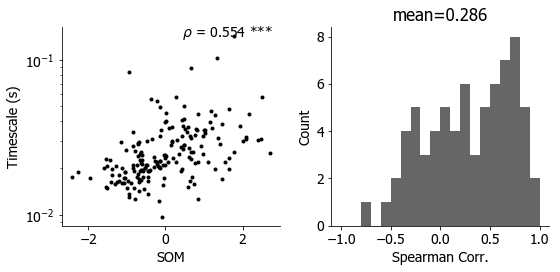

In [136]:
xy_axis_frac = (0.55, 0.95)
struct_feat = 'SOM'
# plot feature on MMP brain
echo_utils.plot_MMP(df_struct[struct_feat].values, fig_path[:-4]%('mmp_%s'%struct_feat))

df_tau_threshed = df_tau_weighted[df_W_max>=w_thres]
tau_parcel = compute_weighted_average(df_tau_weighted, df_W_max, w_thres, method='weighted')

# plot grand average value on MMP
echo_utils.plot_MMP(tau_parcel, fig_path[:-4]%('mmp_tau_%i'%d_query), minmax=[0,0.05])

# group average correlation
rho, pv = stats.spearmanr(df_struct[struct_feat], tau_parcel, nan_policy='omit')

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(df_struct[struct_feat], tau_parcel, '.k')
plt.yscale('log');
plt.xlabel(struct_feat); plt.ylabel('Timescale (s)'); sns.despine()
s = r'$\rho$ = %.3f '%rho + np.sum(pv<=np.array([0.05, 0.01, 0.001]))*'*'
plt.annotate(s, xy=xy_axis_frac, xycoords='axes fraction')

# per-subject correlation
min_parcels = 10
df_subj_corr = pd.DataFrame(index=df_tau_weighted.index, columns=['n_parcels', 'rho', 'pv'])
for i_s, subj in df_tau_threshed.iterrows():
    df_subj_corr['n_parcels'].loc[i_s] = (~np.isnan(subj)).sum()
    if df_subj_corr['n_parcels'].loc[i_s]>=3:
        rho, pv = stats.spearmanr(df_struct[struct_feat], subj, nan_policy='omit')
    else:
        rho, pv = np.nan, np.nan
    df_subj_corr['rho'].loc[i_s],df_subj_corr['pv'].loc[i_s] = rho,pv

# only count correlations from subjects that had min # of parcels
corr_valid = df_subj_corr[df_subj_corr['n_parcels']>=min_parcels]['rho'].values.astype(float)

plt.subplot(1,2,2)
plt.hist(corr_valid, bins=np.arange(-1,1.1,0.1), color='k', alpha=0.6)
plt.xlabel('Spearman Corr.');plt.ylabel('Count');sns.despine()
plt.title('mean=%.3f'%np.nanmean(corr_valid));
plt.tight_layout()
plt.savefig(fig_path[:-4]%('mmp_tau_%s_%i'%(struct_feat,d_query)), bbox_inches='tight')

# Age-related Changes in Tau

### Median Age Split

colormap sequential: [0.00e+00, 2.50e-02, 5.00e-02] (opaque)
colormap sequential: [0.00e+00, 2.50e-02, 5.00e-02] (opaque)
colormap sequential: [-5.00e-02, 0.00e+00, 5.00e-02] (opaque)


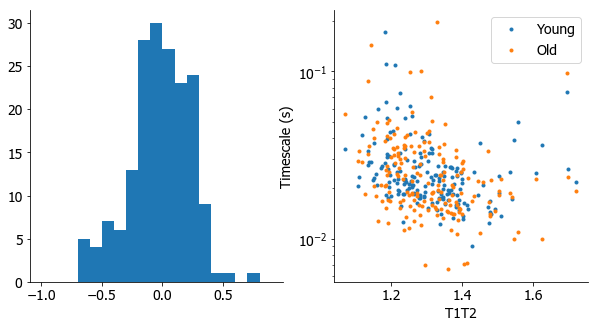

In [14]:
inds_young = df_patient['age']<df_patient['age'].median()
inds_old = df_patient['age']>df_patient['age'].median()

tau_parcel_age = []
for inds in [inds_young, inds_old]:
    tau_parcel_age.append(compute_weighted_average(df_tau_weighted[inds], df_W_max[inds], w_thres, method='weighted'))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(np.log10((tau_parcel_age[1]/tau_parcel_age[0]).values), np.arange(-1,1,0.1))

plt.subplot(1,2,2)
plt.plot(df_struct[struct_feat], tau_parcel_age[0], '.', label='Young')
plt.plot(df_struct[struct_feat], tau_parcel_age[1], '.', label='Old')
plt.yscale('log'); plt.legend()
plt.xlabel(struct_feat);plt.ylabel('Timescale (s)'); sns.despine()

echo_utils.plot_MMP(tau_parcel_age[0].values, fig_path[:-4]%('mmp_tau_young'), minmax=[0,0.05])
echo_utils.plot_MMP(tau_parcel_age[1].values, fig_path[:-4]%('mmp_tau_old'), minmax=[0,0.05])
echo_utils.plot_MMP((tau_parcel_age[1]-tau_parcel_age[0]).values, fig_path[:-4]%('mmp_tau_oldyoung'), minmax=[-0.05,0.05], cmap='coolwarm')

### Average over electrodes per subject

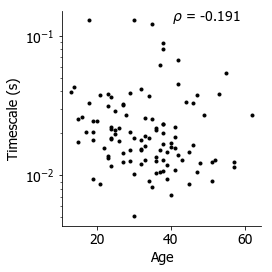

In [15]:
w_thres=0.9
tau_subj = (df_tau_weighted*df_W_max).sum(axis=1)/df_W_max.sum(axis=1)
#tau_subj = np.nanmean(df_tau_weighted[df_W_max>w_thres], axis=1)

rho, pv = stats.spearmanr(df_patient['age'], tau_subj, nan_policy='omit')
plt.figure(figsize=(4,4))
plt.plot(df_patient['age'], tau_subj, '.k')
plt.yscale('log');
plt.xlabel('Age'); plt.ylabel('Timescale (s)'); sns.despine()
s = r'$\rho$ = %.3f '%rho + np.sum(pv<=np.array([0.05, 0.01, 0.001]))*'*'
plt.annotate(s, xy=xy_axis_frac, xycoords='axes fraction')
plt.tight_layout()


# Correlation of Tau & Age By Region

### By Parcel

colormap sequential: [-1.00e+00, 0.00e+00, 1.00e+00] (opaque)


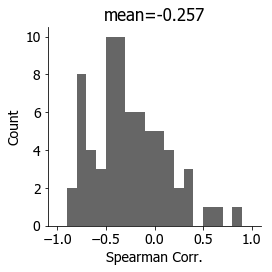

In [59]:
# minimum number of subjects that passed threshold in a parcel to include parcel
min_subjs = 5
df_age_corr=pd.DataFrame(index=df_tau_weighted.columns, columns=['n_subjs', 'rho', 'pv'])
for parcel, col in df_tau_threshed.iteritems():
    df_age_corr['n_subjs'].loc[parcel] = (~np.isnan(col)).sum()
    if df_age_corr['n_subjs'].loc[parcel]>=3:
        rho, pv = stats.spearmanr(df_patient['age'], col, nan_policy='omit')
        df_age_corr['rho'].loc[parcel], df_age_corr['pv'].loc[parcel] = rho, pv
    else:
        df_age_corr['rho'].loc[parcel], df_age_corr['pv'].loc[parcel] = np.nan, np.nan
        
# only count correlations from parcels that had min # of subjs
parcel_corr = df_age_corr['rho']
parcel_corr[df_age_corr['n_subjs']<=min_subjs]=np.nan

plt.figure(figsize=(4,4))
plt.hist(parcel_corr.values.astype(float), bins=np.arange(-1,1.1,0.1), color='k', alpha=0.6)
plt.xlabel('Spearman Corr.');plt.ylabel('Count');sns.despine()
plt.title('mean=%.3f'%np.nanmean(parcel_corr.values));
plt.tight_layout()
plt.savefig(fig_path[:-4]%('mmp_parcel_agecorr_dist_%i'%(d_query)), bbox_inches='tight')

parcel_corr[df_age_corr['n_subjs']<=min_subjs]=0
echo_utils.plot_MMP(parcel_corr.values, fig_path[:-4]%('mmp_parcel_agecorr'), minmax=[-1,1], cmap='coolwarm')

SpearmanrResult(correlation=0.08370852955390921, pvalue=0.48765689467424755)

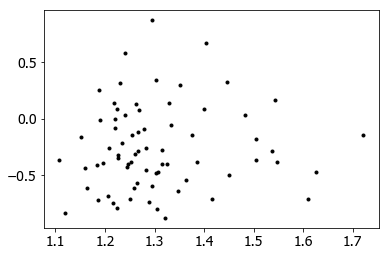

In [60]:
parcel_corr = df_age_corr['rho']
parcel_corr[df_age_corr['n_subjs']<=min_subjs]=np.nan
plt.plot(df_struct['T1T2'], parcel_corr,'k.')
stats.spearmanr(df_struct['T1T2'].values.astype(float), parcel_corr.values.astype(float), nan_policy='omit')

### By Glasser Macro Regions (22)

In [152]:
# aggregating by macro region
df_tau_macro = pd.DataFrame(columns=np.unique(mmp_aggr['macro_region']))
df_struct_macro = pd.DataFrame(columns=np.unique(mmp_aggr['macro_region']))
for i_r, r in mmp_aggr.groupby('macro_region'):
    df_tau_macro[i_r] = compute_weighted_average(df_tau_weighted[r['parcel']], df_W_max[r['parcel']], axis=1, method='thresh_weighted')
    df_struct_macro[i_r] = df_struct.loc[r['parcel']].mean(axis=0)
    
df_struct_macro = df_struct_macro.T

SpearmanrResult(correlation=0.8233766233766234, pvalue=4.5411834094421e-06)

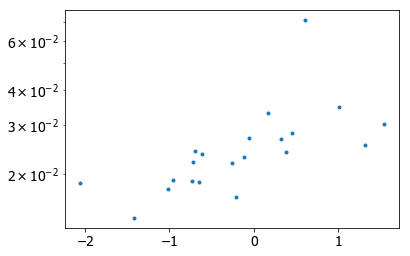

In [192]:
# macro-region level correlation
struct_feat = 'SOM'
plt.plot(df_struct_macro[struct_feat],df_tau_macro.mean(0), '.')
plt.yscale('log')
stats.spearmanr(df_struct_macro[struct_feat],df_tau_macro.mean(0), nan_policy='omit')

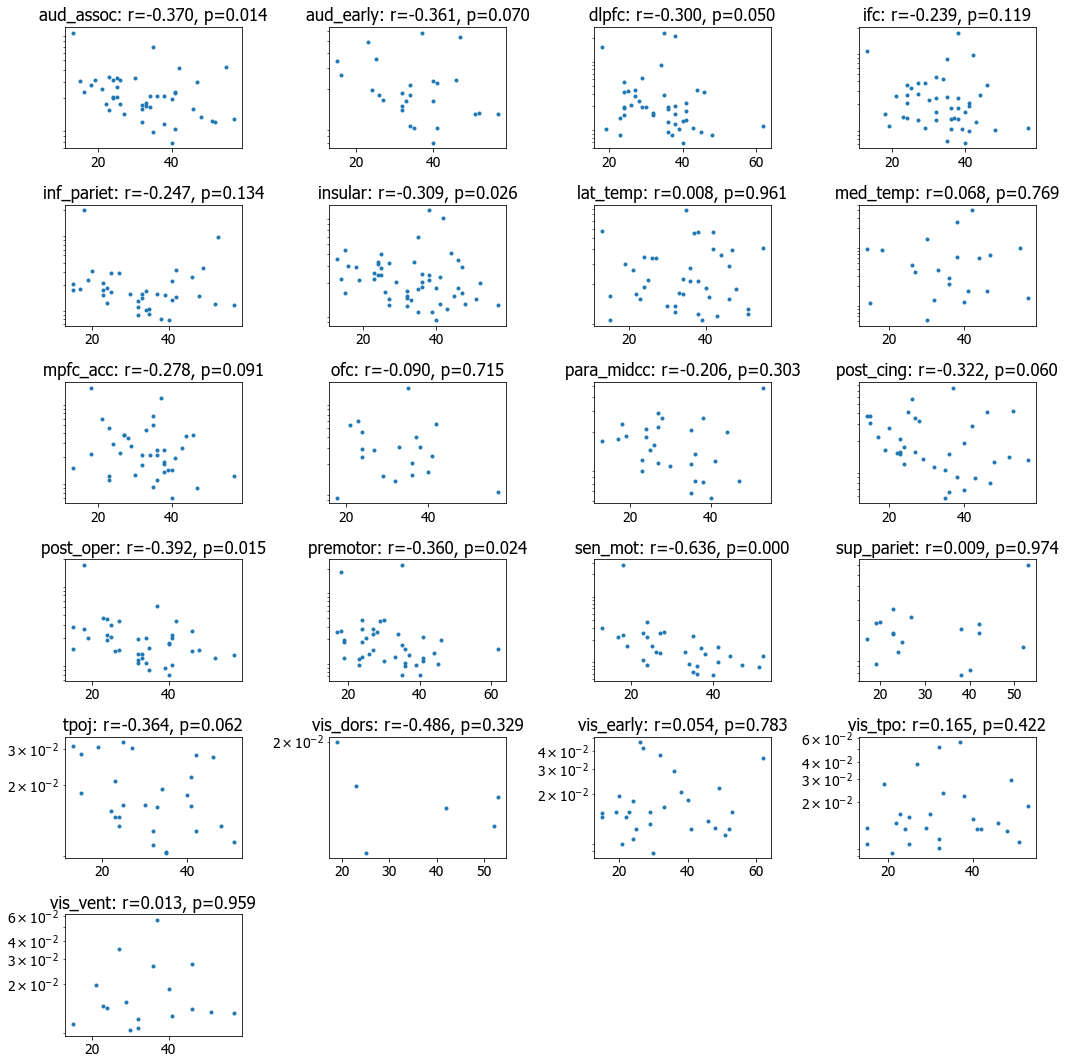

In [177]:
# age correlation
plt.figure(figsize=(15,15))
for i_r, r in enumerate(df_tau_macro.columns):
    plt.subplot(6,4,i_r+1)
    plt.plot(df_patient['age'], df_tau_macro[r], '.')
    rho,pv = stats.spearmanr(df_patient['age'], df_tau_macro[r], nan_policy='omit')
    plt.yscale('log')
    plt.yticks([])
    plt.title('%s: r=%.3f, p=%.3f'%(r,rho,pv))

plt.tight_layout()

### By Quantiles of T1T2 (Cortical Hierarchy)

colormap sequential: [0.00e+00, 2.00e+00, 4.00e+00] (opaque)


/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


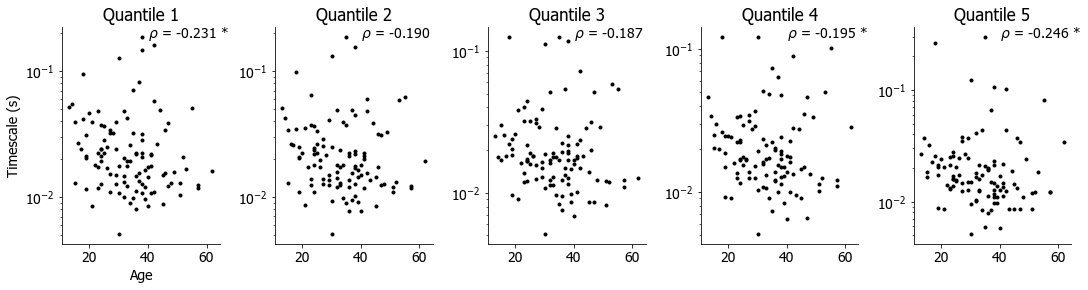

In [188]:
# label the parcels based on quantile of T1T2 value
quants = 5
struct_feat = 'GRIN2B'
parcels_quant = quants-np.digitize(df_struct[struct_feat], np.quantile(df_struct[struct_feat], np.arange(0,1,1/quants)))
echo_utils.plot_MMP(parcels_quant, fig_path[:-4]%('mmp_'+struct_feat+'_quantile'))

plt.figure(figsize=(15,4))
for quant in range(quants):
    plt.subplot(1,quants,quant+1)
    # weighted sum
    tau_avg = (df_tau_weighted*df_W_max).T[parcels_quant==quant].T.sum(axis=1)/df_W_max.T[parcels_quant==quant].T.sum(axis=1)

    # simple average
    # tau_avg = np.nanmean(df_tau_threshed.T[parcels_quant==quant].T,axis=1)

    rho, pv = stats.spearmanr(df_patient['age'], tau_avg, nan_policy='omit')
    plt.plot(df_patient['age'], tau_avg, 'k.')
    s = r'$\rho$ = %.3f '%rho + np.sum(pv<=np.array([0.05, 0.01, 0.001]))*'*'
    plt.annotate(s, xy=xy_axis_frac, xycoords='axes fraction')
    plt.yscale('log'); sns.despine()
    plt.title('Quantile %i'%(quant+1))

plt.tight_layout()
plt.subplot(1,quants,1); plt.xlabel('Age'); plt.ylabel('Timescale (s)')
plt.savefig(fig_path[:-4]%('mmp_tau_age_quantile%i'%(d_query)), bbox_inches='tight')
